todo:
- make check if done, template matching on clouds
- or first teach it 1v1 in marathon mode detect points or even time by every time the time refreshes you get another score?

Environment Configuration
- Start Dolphin
- Load save state f1
- in the worst case scenario set it up manually player1=ash player2=gary

1. Imports Versioning

In [1]:
import gymnasium as gym
import matplotlib
import torch
import torchvision
import torchaudio
import pyautogui
import numpy as np

print(gym.__version__)          # 0.29.1
print(matplotlib.__version__)   # 3.9.2
print(torch.__version__)        # 2.4.1+cpu
print(torchvision.__version__)  # 0.19.1+cpu
print(torchaudio.__version__)   # 2.4.1+cpu
print(pyautogui.__version__)    # 0.9.54
print(np.__version__)           # 1.26.4

0.29.1
3.9.2
2.4.1+cpu
0.19.1+cpu
2.4.1+cpu
0.9.54
1.26.4


2. Initialise Environment, Model & Agent

In [2]:
from DQNCNN import DQNCNN
from DQNAgent import DQNAgent
from PPLEnv import PPLEnv

# States
P1_CELL_BBOX_PJ64 = (348, 130, 830, 1004)
P1_CELL_BBOX_DOLPHIN = (390, 160, 845, 960)
STACK_SIZE = 4 # amount of frames stacked
CHANNEL_AMOUNT = 3 # RGB

env = PPLEnv(state_bbox=P1_CELL_BBOX_PJ64, mode='color', stack_size=STACK_SIZE)
ACTION_SIZE = env.action_space.n
deep_q_learning_model = DQNCNN(action_size=ACTION_SIZE, stack_size=STACK_SIZE, channels=CHANNEL_AMOUNT)
agent = DQNAgent(DQNCNN=deep_q_learning_model, action_size=ACTION_SIZE)
env.action_space.n

6

3. Training Loop

In [ ]:
from helper import alt_tab
import time
import keyboard

# Training loop
num_episodes = 1
alt_tab()

for e in range(num_episodes):
    # Reset the environment and get the initial state (stacked frames managed by PPLEnv)
    state, _ = env.reset()  # Initial state, includes stacked frames
    keyboard.press('f1')
    time.sleep(.1)
    keyboard.release('f1')
    time.sleep(.1)
    done = False
    total_reward = 0
    
    while not done:
        # Use the state directly as the stacked frames (already handled by PPLEnv)
        action = agent.select_action(state)  # Select action (can be exploration or exploitation)
        
        # Perform the action in the environment and get the next state and reward
        next_state, reward, done, _, _ = env.step(action)

        # Store experience in replay memory
        agent.memory.add((state, action, reward, next_state, done))

        # Train the agent with experience replay
        agent.replay()

        # Update the state (stacked frames already handled by PPLEnv)
        state = next_state  # Update to the new state (stacked frame after the action)
        
        total_reward += reward

        # Periodically update target network
        if e % agent.update_frequency == 0:
            agent.update_target_network()

    print(f"Episode: {e+1}/{num_episodes}, Total Reward: {total_reward}")

env.close()
alt_tab()


Episode: 1/1, Total Reward: 43


# You are entering the kitchen

In [5]:
import pyautogui
from PIL import ImageGrab

# Coordinates of the pixel (x, y)
x, y = 100, 150  # Example coordinates (100, 150)

# Capture the screen at a single pixel location
screenshot = ImageGrab.grab(bbox=(x, y, x+1, y+1))  # Captures a 1x1 pixel region

# Get the color of the pixel at (x, y)
pixel_color = screenshot.getpixel((0, 0))  # (0, 0) because it's a 1x1 region

# Print the color
print(f"The color of the pixel at ({x}, {y}) is: {pixel_color}")

The color of the pixel at (100, 150) is: (24, 24, 24)


In [26]:
import pyautogui
from PIL import ImageGrab, ImageDraw

# Coordinates of the pixel (x, y)
x, y = 400, 965  # Example coordinates (100, 150)

# Capture the screen at a single pixel location
alt_tab()
range=40
screenshot = ImageGrab.grab(bbox=(400, 965, 440, 1005))  # 10x10 region centered on the pixel

# Show the screenshot with the red circle
screenshot.show()

# Get the color of the pixel at (x, y)
pixel_color = screenshot.getpixel((3, 3))  # The pixel is at the center of the 10x10 region

# Print the color
print(f"The color of the pixel at ({x}, {y}) is: {pixel_color}")
alt_tab()

The color of the pixel at (400, 965) is: (75, 89, 190)


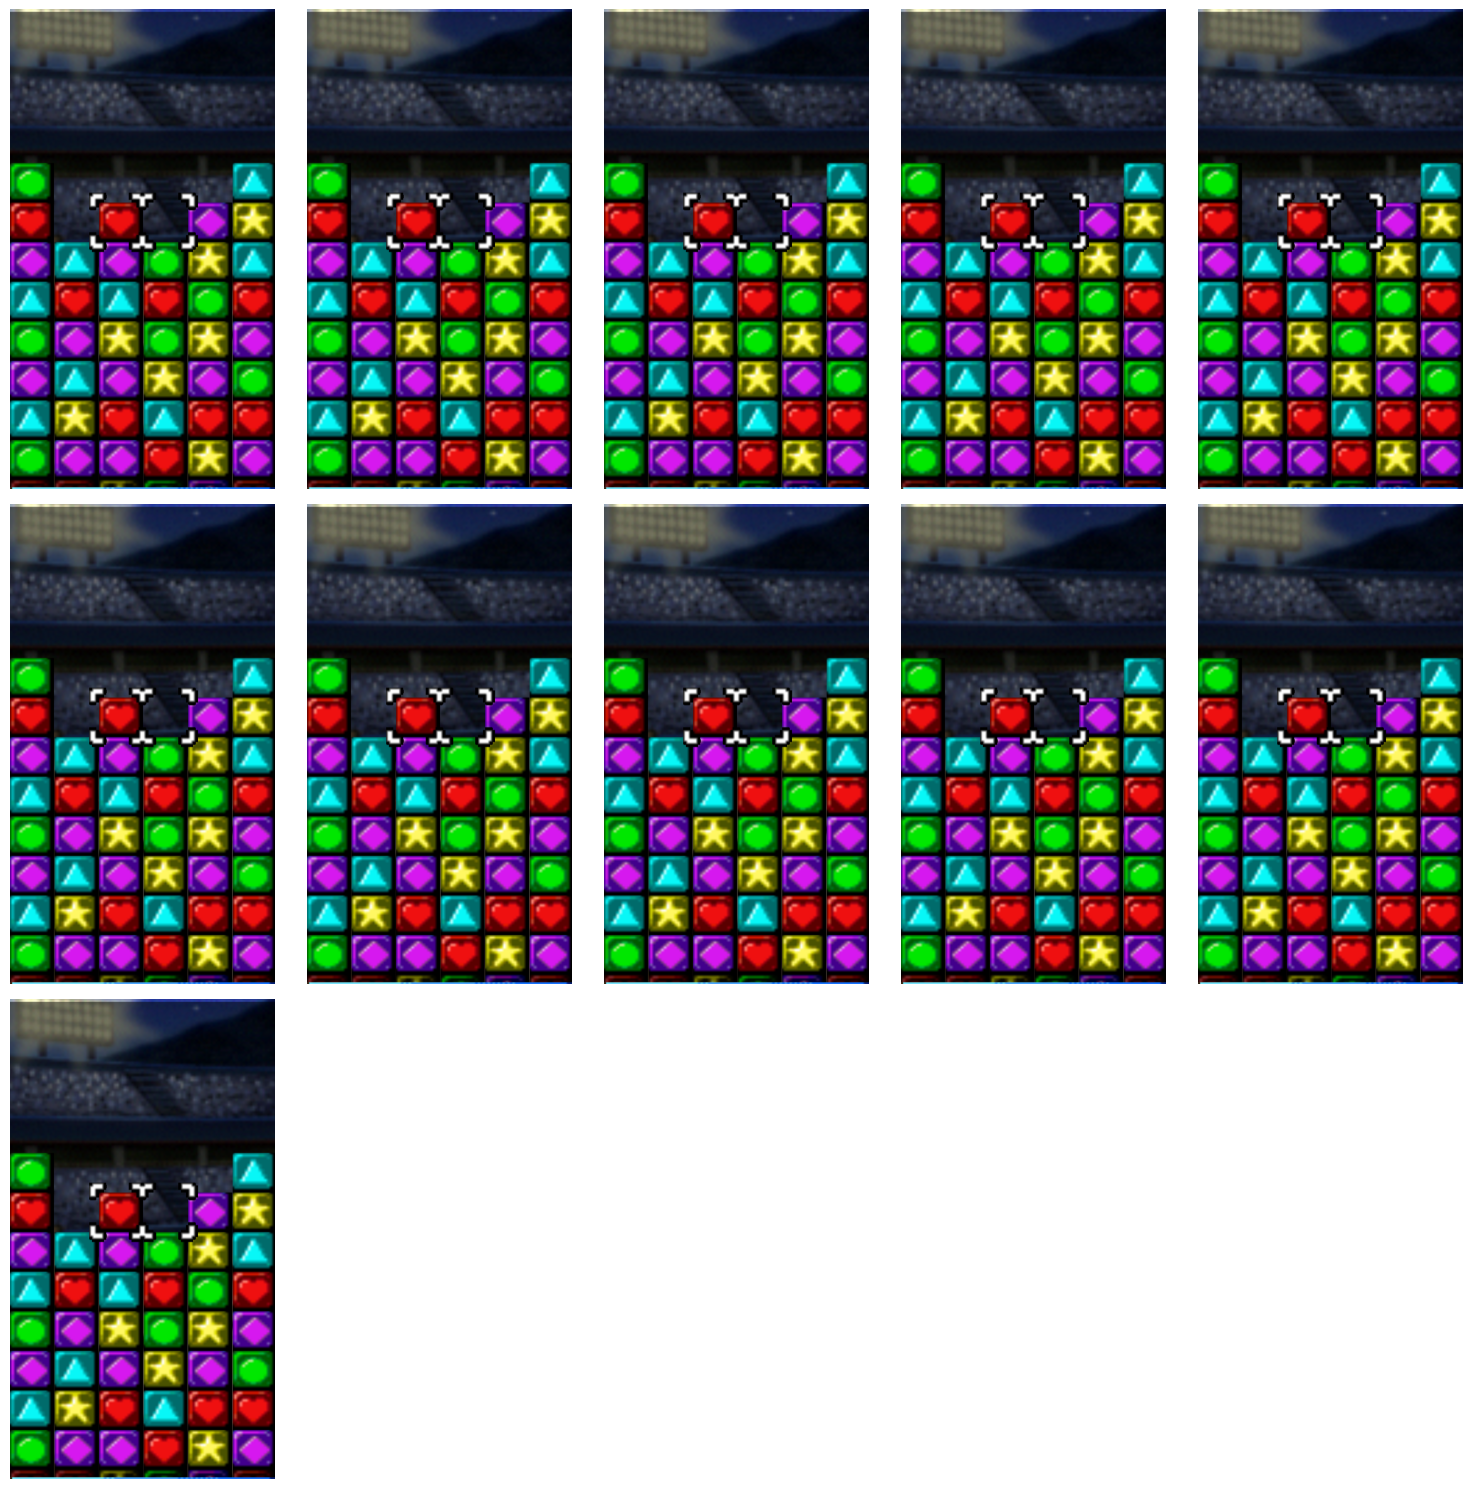

In [ ]:
env.preprocessed_screenshot_history

import matplotlib.pyplot as plt

# Your list of images
images = env.preprocessed_screenshot_history

# Number of images
num_images = len(images)

# Determine the grid size (rows and columns)
cols = 5  # Number of images per row
rows = (num_images + cols - 1) // cols  # Calculate number of rows needed

# Create a figure for plotting
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

# Flatten axes for easy iteration, and handle extra empty plots
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < num_images:
        # Convert PIL image to array for matplotlib
        ax.imshow(images[i])
        ax.axis('off')  # Turn off axes
    else:
        # Turn off unused axes
        ax.axis('off')

plt.tight_layout()
plt.show()

In [9]:
for i, frame in enumerate(env.frames):
    print(f"Shape of tensor {i + 1}: {frame.shape}")

Shape of tensor 1: torch.Size([3, 64, 64])
Shape of tensor 2: torch.Size([3, 64, 64])
Shape of tensor 3: torch.Size([3, 64, 64])
Shape of tensor 4: torch.Size([3, 64, 64])
Shape of tensor 5: torch.Size([3, 64, 64])
Shape of tensor 6: torch.Size([3, 64, 64])
Shape of tensor 7: torch.Size([3, 64, 64])
Shape of tensor 8: torch.Size([3, 64, 64])
Shape of tensor 9: torch.Size([3, 64, 64])
Shape of tensor 10: torch.Size([3, 64, 64])


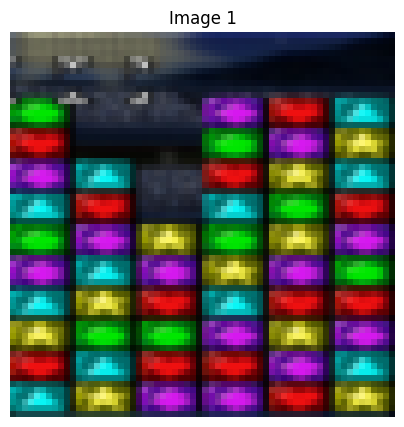

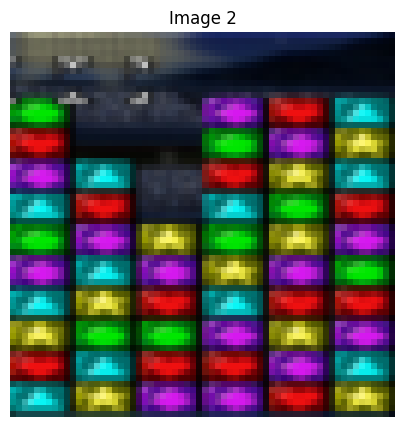

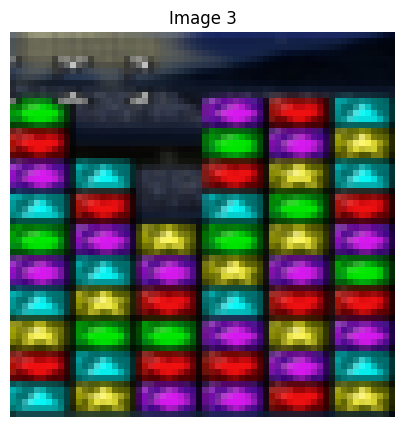

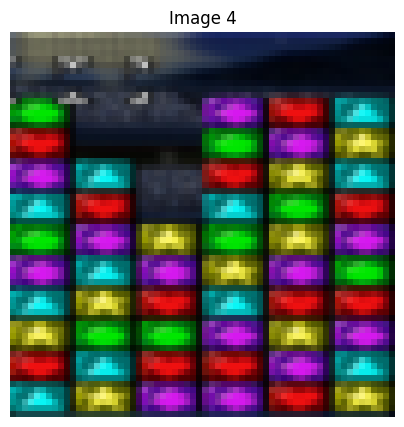

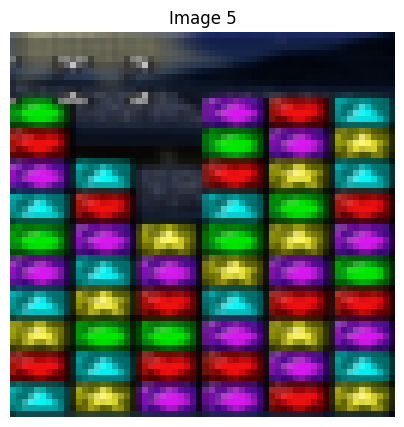

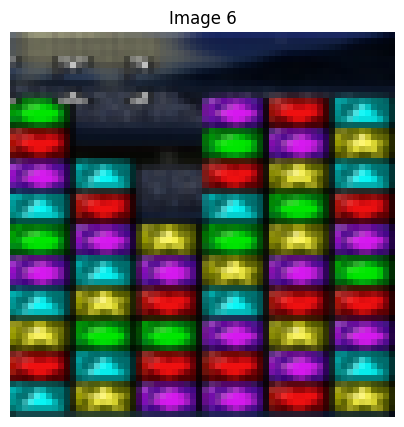

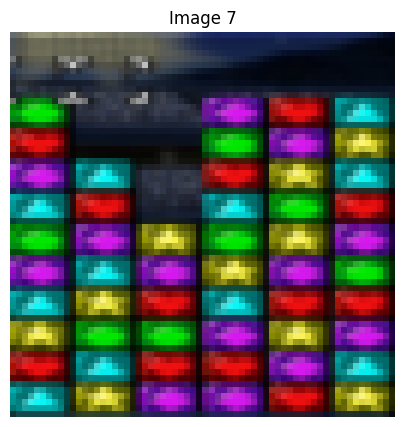

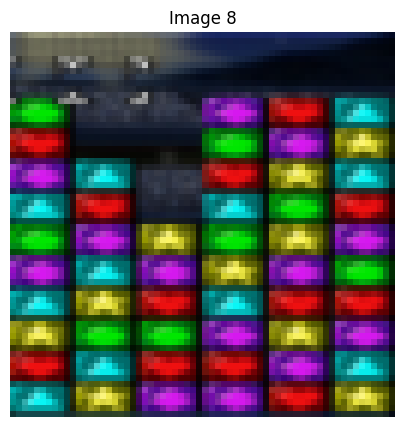

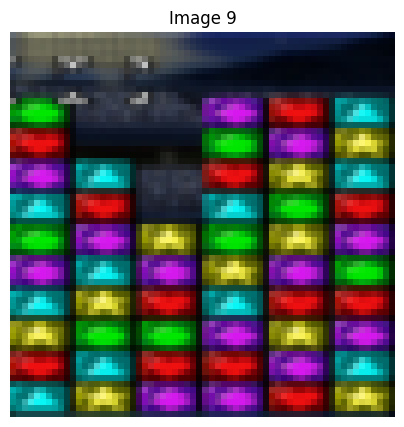

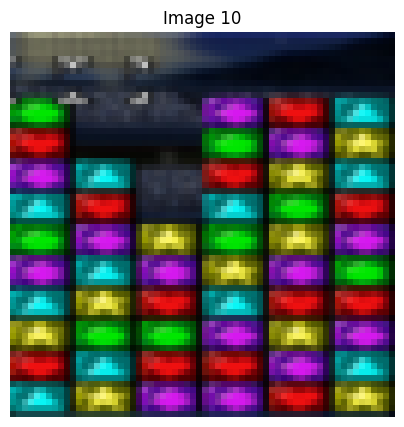

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from collections import deque


frames = env.frames

# Loop through the deque and visualize each tensor
for i, frame in enumerate(frames):
    # Convert the tensor to a NumPy array
    image_array = frame.numpy()

    # Rearrange dimensions from [C, H, W] to [H, W, C] for visualization
    image_array = np.transpose(image_array, (1, 2, 0))

    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(image_array)
    plt.title(f"Image {i + 1}")
    plt.axis("off")
    plt.show()

s1. Figure out how to wake up P64

In [ ]:
import time
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from PIL import ImageGrab, Image
import pyautogui
import win32gui
import cv2
import win32con
from torchvision import transforms
from collections import deque
import keyboard
import pyautogui
from helper import alt_tab
from DQNCNN import DQNCNN
from DQNAgent import DQNAgent
from PPLEnv import PPLEnv


P1_CELL_BBOX_DOLPHIN = (390, 160, 845, 960)
TIME_BBOX_DOLPHIN = (980, 690, 990, 720)
TIME_BBOX_DOLPHIN = (960, 670, 1045, 732)
CLOUD_BBOX_DOLPHIN = (390, 70, 845, 155) 

STACK_SIZE = 4
env = PPLEnv(state_bbox=P1_CELL_BBOX_DOLPHIN, mode='color', stack_size=STACK_SIZE)
ACTION_SIZE = env.action_space.n
deep_q_learning_model = DQNCNN(action_size=ACTION_SIZE, stack_size=STACK_SIZE, channels=3)
agent = DQNAgent(DQNCNN=deep_q_learning_model, action_size=ACTION_SIZE)

cloud_history = []
alt_tab()
for x in range(50):
    env.step(agent.random_action())
    cloud_history.append(ImageGrab.grab(bbox=CLOUD_BBOX_DOLPHIN)) # PIL
alt_tab()



In [15]:
cloud_history[24].save('case_5.png')

In [7]:
import cv2
import numpy as np
import time
from PIL import Image

# Load the templates
template1 = cv2.imread("temp_img1.png")  # Replace with your first template image path
template2 = cv2.imread("temp_img2.png")  # Replace with your second template image path

# Convert the templates to grayscale
template1_gray = cv2.cvtColor(template1, cv2.COLOR_BGR2GRAY)
template2_gray = cv2.cvtColor(template2, cv2.COLOR_BGR2GRAY)

# Start the timer
start_time = time.time()

# Load the input image (cloud_history[30] should be a PIL image)
input_img = cloud_history[30]  # PIL image

# Convert the PIL image to a NumPy array (BGR format)
input_img = np.array(input_img)

# Convert the input image to grayscale
input_gray = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)

# Perform template matching for both templates
result1 = cv2.matchTemplate(input_gray, template1_gray, cv2.TM_CCOEFF_NORMED)
result2 = cv2.matchTemplate(input_gray, template2_gray, cv2.TM_CCOEFF_NORMED)

# Get the best match positions and scores for both templates
min_val1, max_val1, min_loc1, max_loc1 = cv2.minMaxLoc(result1)
min_val2, max_val2, min_loc2, max_loc2 = cv2.minMaxLoc(result2)

# Take the maximum accuracy from both templates
best_accuracy = max(max_val1, max_val2)

# Print the best accuracy (similarity score)
print(f"Best Template Matching Accuracy: {best_accuracy:.4f}")
if best_accuracy > 0.85:
    print('ah shit we dead')

# End the timer and print the elapsed time
end_time = time.time()
print(f"Time taken: {end_time - start_time:.4f} seconds")


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


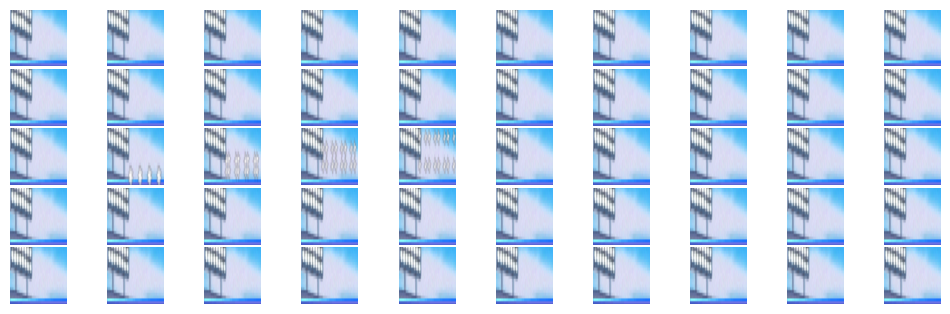

In [12]:
import matplotlib.pyplot as plt
from PIL import Image

# Your list of PIL images
images = cloud_history

# Number of images
num_images = len(images)

# Determine the grid size (rows and columns)
cols = 10  # Number of images per row
rows = (num_images + cols - 1) // cols  # Calculate number of rows needed

# Create a figure for plotting with a smaller size
fig, axes = plt.subplots(rows, cols, figsize=(10, 3))  # Smaller figure size

# Flatten axes for easy iteration, and handle extra empty plots
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < num_images:
        # Get the PIL image from the list
        img = images[i]
        
        # Resize image to fit better
        img_resized = img.resize((256, 256))  # Resize the image to 64x64 (or any size you prefer)
        
        # Display the resized image
        ax.imshow(img_resized)
        ax.axis('off')  # Turn off axes
    else:
        # Turn off unused axes
        ax.axis('off')

# Adjust layout to fit everything in
plt.tight_layout(pad=.2)  # Adjust padding if needed
plt.show()


s2. Visualize

AttributeError: 'Image' object has no attribute 'shape'

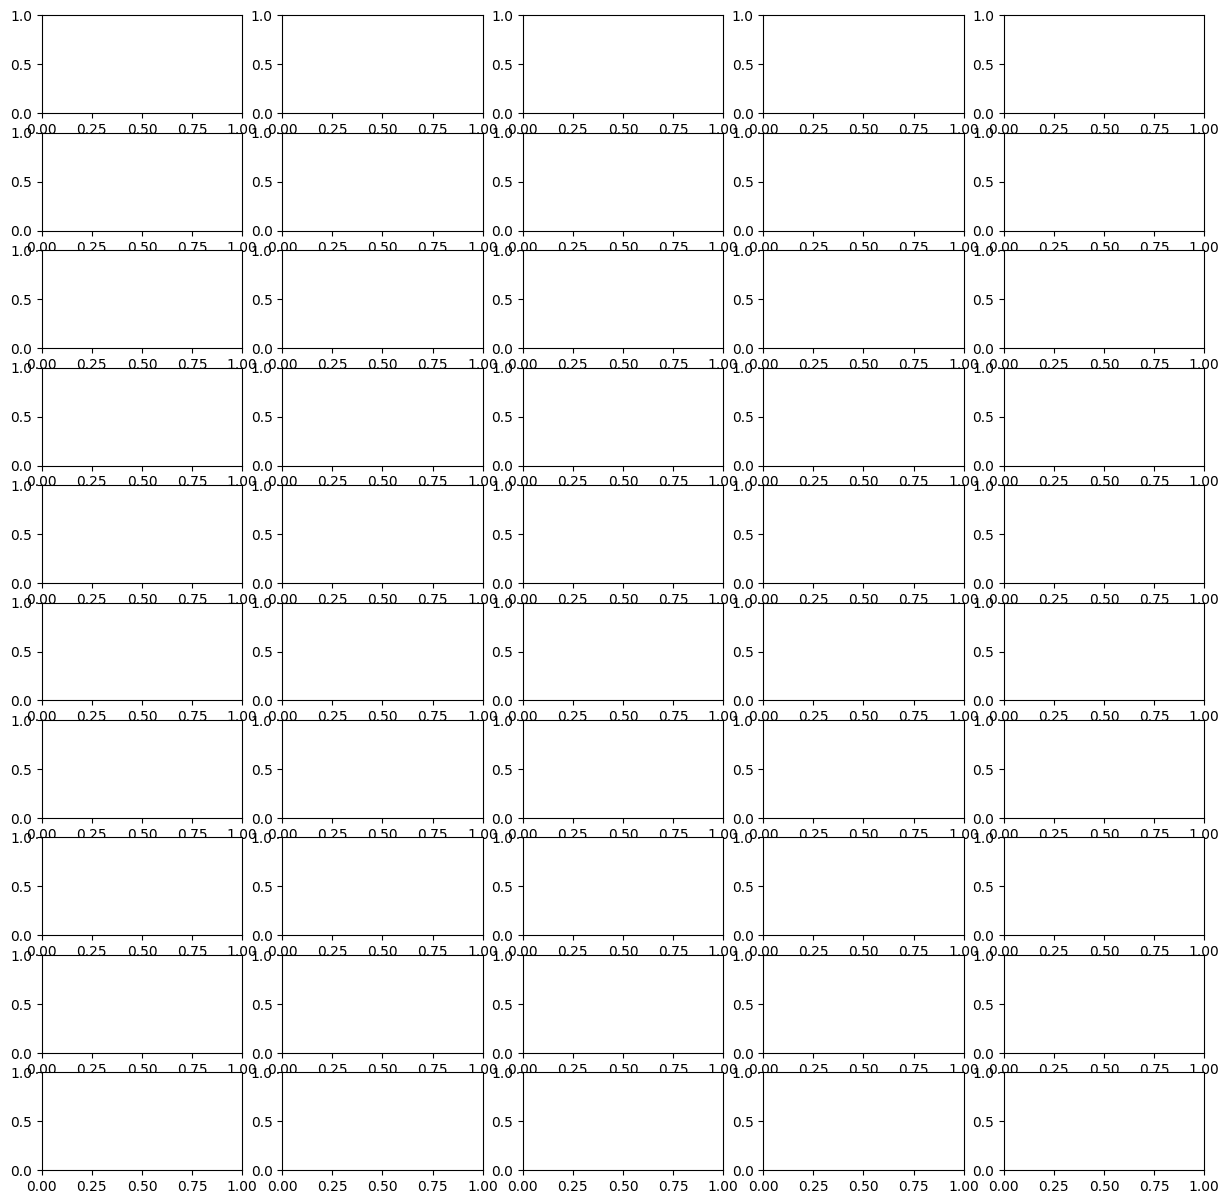

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Your list of images (assuming this is a list of 3x64x64 images)
images = env.preprocessed_screenshot_history

# Number of images
num_images = len(images)

# Determine the grid size (rows and columns)
cols = 5  # Number of images per row
rows = (num_images + cols - 1) // cols  # Calculate number of rows needed

# Create a figure for plotting
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

# Flatten axes for easy iteration, and handle extra empty plots
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < num_images:
        image = images[i]

        # Check the shape of the image, and if needed, transpose it to (height, width, 3)
        if image.shape[0] == 3:  # If it's (3, height, width)
            image = np.transpose(image, (1, 2, 0))  # Convert it to (height, width, 3)

        ax.imshow(image)
        ax.axis('off')  # Turn off axes
    else:
        # Turn off unused axes
        ax.axis('off')

plt.tight_layout()
plt.show()
